In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


##**Install & Import Dependencies**

In [ ]:
!pip install torchvision --quiet

In [ ]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Set up paths
base_path = '/content/drive/MyDrive/MSc in DS & AI/Advanced ML/GAN Assignment 2'
model_path = os.path.join(base_path, 'Models')
fake_path = os.path.join(base_path, 'Fake_Digits')

os.makedirs(model_path, exist_ok=True)
os.makedirs(fake_path, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST datase
train_set = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_set = datasets.MNIST(root='./data', train=False, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 45.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 34.6MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 37.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.99MB/s]


##**Define GAN Architecture**

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.model(z).view(-1, 1, 28, 28)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.model(x)

##**Train the GAN**

In [ ]:
epochs = 100
z_dim = 100
g_loss_log, d_loss_log = [], []

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

for epoch in range(epochs):
    total_real_correct = 0
    total_fake_correct = 0
    total_samples = 0

    for real, _ in train_loader:
        real = real.to(device)
        bs = real.size(0)
        z_latent = torch.randn(bs, z_dim).to(device)
        fake = G(z_latent)

        D_real = D(real)
        D_fake = D(fake.detach())

        # Train the Discriminator
        loss_D = loss_fn(D_real, torch.ones_like(D_real)) + loss_fn(D_fake, torch.zeros_like(D_fake))
        opt_D.zero_grad(); loss_D.backward(); opt_D.step()

        # Calculate Accuracy
        real_correct = (D_real > 0.5).sum().item()
        fake_correct = (D_fake < 0.5).sum().item()
        total_real_correct += real_correct
        total_fake_correct += fake_correct
        total_samples += bs * 2

        # Train the Generator
        D_fake = D(fake)
        loss_G = loss_fn(D_fake, torch.ones_like(D_fake))
        opt_G.zero_grad(); loss_G.backward(); opt_G.step()

    g_loss_log.append(loss_G.item())
    d_loss_log.append(loss_D.item())

    acc = (total_real_correct + total_fake_correct) / total_samples * 100
    print(f"Epoch {epoch+1}/{epochs} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f} | D Accuracy: {acc:.2f}%")

Epoch 1/100 | D Loss: 1.1878 | G Loss: 1.5709 | D Accuracy: 66.48%
Epoch 2/100 | D Loss: 1.3623 | G Loss: 2.1987 | D Accuracy: 69.81%
Epoch 3/100 | D Loss: 1.1118 | G Loss: 1.0495 | D Accuracy: 69.52%
Epoch 4/100 | D Loss: 1.2612 | G Loss: 0.5625 | D Accuracy: 69.19%
Epoch 5/100 | D Loss: 1.1078 | G Loss: 1.0792 | D Accuracy: 68.29%
Epoch 6/100 | D Loss: 1.1407 | G Loss: 0.9124 | D Accuracy: 68.25%
Epoch 7/100 | D Loss: 1.1635 | G Loss: 0.9850 | D Accuracy: 67.93%
Epoch 8/100 | D Loss: 1.5040 | G Loss: 0.2675 | D Accuracy: 66.41%
Epoch 9/100 | D Loss: 1.2659 | G Loss: 1.1246 | D Accuracy: 65.55%
Epoch 10/100 | D Loss: 1.1520 | G Loss: 0.9618 | D Accuracy: 65.50%
Epoch 11/100 | D Loss: 1.2082 | G Loss: 0.8814 | D Accuracy: 63.91%
Epoch 12/100 | D Loss: 1.2693 | G Loss: 0.9004 | D Accuracy: 63.14%
Epoch 13/100 | D Loss: 1.3352 | G Loss: 0.8270 | D Accuracy: 63.23%
Epoch 14/100 | D Loss: 1.3727 | G Loss: 0.9280 | D Accuracy: 62.91%
Epoch 15/100 | D Loss: 1.3006 | G Loss: 0.8075 | D Accura

In [ ]:
torch.save(G.state_dict(), os.path.join(model_path, 'G.pkl'))
torch.save(D.state_dict(), os.path.join(model_path, 'D.pkl'))

##**Generate 100 Fake Digits**

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
import os
import numpy as np

# Load trained generator
G = Generator().to(device)
G.load_state_dict(torch.load(os.path.join(model_path, 'G.pkl')))
G.eval()

# Create the save path
unlabeled_path = os.path.join(fake_path, 'Unlabeled')
os.makedirs(unlabeled_path, exist_ok=True)

# Generate 100 latent vectors
z_vectors = torch.randn(100, 100).to(device)

# Generate fake digit images
with torch.no_grad():
    fake_images = G(z_vectors).cpu()

# Normalize to [0, 1] for saving
fake_images = (fake_images + 1) / 2

# Save individual images and Z vectors
to_pil = transforms.ToPILImage()

for i in range(100):
    # Save image
    img = to_pil(fake_images[i])
    img_name = f"{i:03}.png"
    img.save(os.path.join(unlabeled_path, img_name))

    # Save corresponding latent vector
    z_name = f"{i:03}.txt"
    np.savetxt(os.path.join(unlabeled_path, z_name), z_vectors[i].cpu().numpy(), fmt="%.6f")

print("100 fake digit images and latent vectors saved.")


100 fake digit images and latent vectors saved.


##**10x10 Grid of Fake Digits**

In [ ]:
grid = vutils.make_grid(fake_images, nrow=10, padding=2, normalize=True)
grid_image = transforms.ToPILImage()(grid)
grid_image.save(os.path.join(unlabeled_path, 'grid.png'))

print("10x10 grid image saved as 'grid.png'")

10x10 grid image saved as 'grid.png'


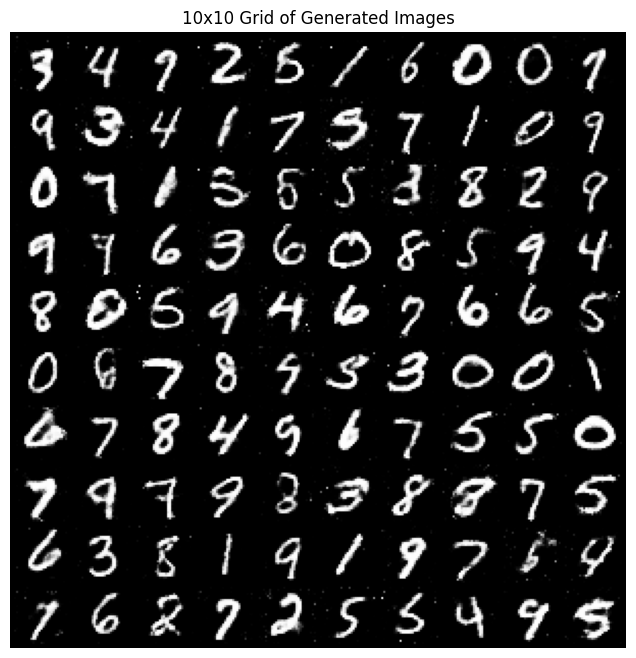

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(grid_image, cmap='gray')
plt.axis('off')
plt.title("10x10 Grid of Generated Images")
plt.show()

##**CNN Classifier for MNIST**

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

###Train Classifier

In [ ]:
classifier = Classifier().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    classifier.train()
    correct, total = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = classifier(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    acc = correct / total
    print(f"[Epoch {epoch+1}] Classifier Train Accuracy: {acc:.4f}")

torch.save(classifier.state_dict(), os.path.join(model_path, 'C.pkl'))

[Epoch 1] Classifier Train Accuracy: 0.9489
[Epoch 2] Classifier Train Accuracy: 0.9861
[Epoch 3] Classifier Train Accuracy: 0.9909
[Epoch 4] Classifier Train Accuracy: 0.9938
[Epoch 5] Classifier Train Accuracy: 0.9953
[Epoch 6] Classifier Train Accuracy: 0.9968
[Epoch 7] Classifier Train Accuracy: 0.9967
[Epoch 8] Classifier Train Accuracy: 0.9974
[Epoch 9] Classifier Train Accuracy: 0.9976
[Epoch 10] Classifier Train Accuracy: 0.9979


###Test Classifier

In [ ]:
classifier.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = classifier(x)
        preds = outputs.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
test_acc = correct / total
print(f"Classifier Test Accuracy on Full MNIST: {test_acc * 100:.2f}%")

Classifier Test Accuracy on Full MNIST: 98.75%


###Extract S0 from MNIST Test Set (100 Samples)

In [ ]:
from torch.utils.data import Subset
import numpy as np

np.random.seed(42)
s0_indices = np.random.choice(len(test_set), 100, replace=False)
s0_set = Subset(test_set, s0_indices)
s0_loader = DataLoader(s0_set, batch_size=100, shuffle=False)

###Load S1 (Fake_Digits) Dataset

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.io import read_image

s1_path = '/content/drive/MyDrive/MSc in DS & AI/Advanced ML/GAN Assignment 2/Fake_Digits'
s1_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

s1_dataset = ImageFolder(root=s1_path, transform=s1_transform)
s1_loader = DataLoader(s1_dataset, batch_size=100, shuffle=False)

###S0 and S1 Error Reporting

In [ ]:
def evaluate(loader, name):
    classifier.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = classifier(x).argmax(dim=1)
            error = 1 - (preds == y).sum().item() / len(y)
            print(f"Classification Error on {name}: {error:.2f}")
            return error

error_s0 = evaluate(s0_loader, "S0")
error_s1 = evaluate(s1_loader, "S1")

Classification Error on S0: 0.01
Classification Error on S1: 0.90
